In [12]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_score, recall_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate


In [15]:
train_df = pd.read_feather("aggregated_train_data.ftr")
test_df = pd.read_feather("aggregated_test_data.ftr")
labels_df = pd.read_feather("train_labels.ftr")

In [21]:
intersection_train_labels = np.intersect1d(train_df["customer_ID"], labels_df["customer_ID"]).tolist()
intersection_test_labels = np.intersect1d(test_df["customer_ID"], labels_df["customer_ID"]).tolist()
train_y = labels_df.loc[labels_df["customer_ID"].isin(intersection_train_labels),:]
test_y = labels_df.loc[labels_df["customer_ID"].isin(intersection_test_labels),:]
print(train_y)

                                              customer_ID  target
0       0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1       00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2       00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3       000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4       00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0
...                                                   ...     ...
367140  cc8c8b1beb85f1d0b7155002ff1293372dfe6d0ab9c3b5...       0
367141  cc8cbbacc5aa58ade43f8b8aafd09503f78955af26e705...       0
367142  cc8cd9c356819e896a6c47aca5f6c01afc5b7f3d16a807...       0
367143  cc8ceac794723983c2d6bf0e9bf9300de570f955fb3333...       0
367144  cc8ceb38279db6383b9acfe936d57f9032f032f124f2f3...       0

[367145 rows x 2 columns]


In [23]:
xgboost_parameters = {
    'verbosity': 1,
    'max_depth':4, 
    'learning_rate':0.04, 
    'subsample':0.71,
    'colsample_bytree':0.72, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method': 'gpu_hist'
    }


In [24]:
train_df = train_df.drop(columns=["customer_ID"])
test_df = test_df.drop(columns=["customer_ID"])
train_y = train_y.drop(columns=["customer_ID"])
test_y = test_y.drop(columns=["customer_ID"])

In [25]:
xgb_clf = xgb.XGBClassifier(**xgboost_parameters)
print(xgb_clf.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.72, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.04, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.71, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': 1}


In [26]:
cv_results = cross_validate(xgb_clf, train_df, train_y["target"], cv=5, scoring=('roc_auc', 'precision', 'recall'), return_train_score=True)
print(sorted(cv_results.keys()))

['fit_time', 'score_time', 'test_precision', 'test_recall', 'test_roc_auc', 'train_precision', 'train_recall', 'train_roc_auc']


In [27]:
print("Precision on validation set: " , cv_results['test_precision'])
print("Recall on validation set: " , cv_results['test_recall'])
print("Roc_auc on validation set: " , cv_results['test_roc_auc'])
print("---------------------")
print("Precision on train set: " , cv_results['train_precision'])
print("Recall on train set: " , cv_results['train_recall'])
print("Roc_auc on train set: " , cv_results['train_roc_auc'])



Precision on validation set:  [0.79137301 0.78948473 0.78670302 0.79201182 0.79350066]
Recall on validation set:  [0.78426636 0.79014809 0.78790107 0.78826866 0.78858373]
Roc_auc on validation set:  [0.9514161  0.95125443 0.95136867 0.95308903 0.9532738 ]
---------------------
Precision on train set:  [0.79322016 0.79310981 0.79318917 0.79272062 0.79298578]
Recall on train set:  [0.79072088 0.79064211 0.79168964 0.79119076 0.79020612]
Roc_auc on train set:  [0.95347065 0.95348369 0.95345669 0.95315149 0.95316191]


In [35]:
def display_metrics(predictor,y_true, y_pred_labels, y_pred_score):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    accuracy = accuracy_score(y_true, y_pred_labels)
    print("Accuracy: ", accuracy)
    precision = precision_score(y_true, y_pred_labels)
    print("Precision score: ", precision)
    recall = recall_score(y_true, y_pred_labels)
    print("Recall score: ", recall)
    f1 = f1_score(y_true, y_pred_labels)
    print("F1 score: ", f1)
    rocauc = roc_auc_score(y_true, y_pred_labels)
    print("roc_auc score: ", rocauc)
    conf_matrix = confusion_matrix(y_true, y_pred_labels)
    fpr, tpr, _ = roc_curve(y_true, y_pred_score[:, 1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=predictor.classes_).plot(ax=ax1)


In [29]:
xgb_clf.fit(train_df, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.72,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.04, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Accuracy:  0.8921052989963094
Precision score:  0.7926993619575059
Recall score:  0.790742860743806
F1 score:  0.7917199026242041
roc_auc score:  0.8591693651497151


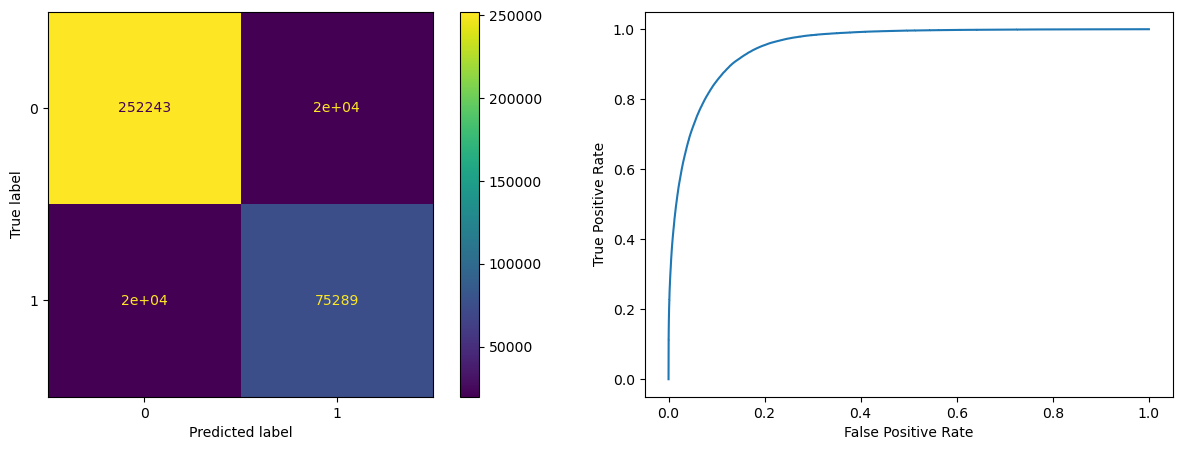

In [39]:
pred_train_y = xgb_clf.predict(train_df)
pred_proba_train_y = xgb_clf.predict_proba(train_df)
display_metrics(xgb_clf, train_y, pred_train_y, pred_proba_train_y)

Accuracy:  0.8922947836415347
Precision score:  0.7896468801417542
Recall score:  0.7925894558543298
F1 score:  0.7911154317595841
roc_auc score:  0.8597158037260908


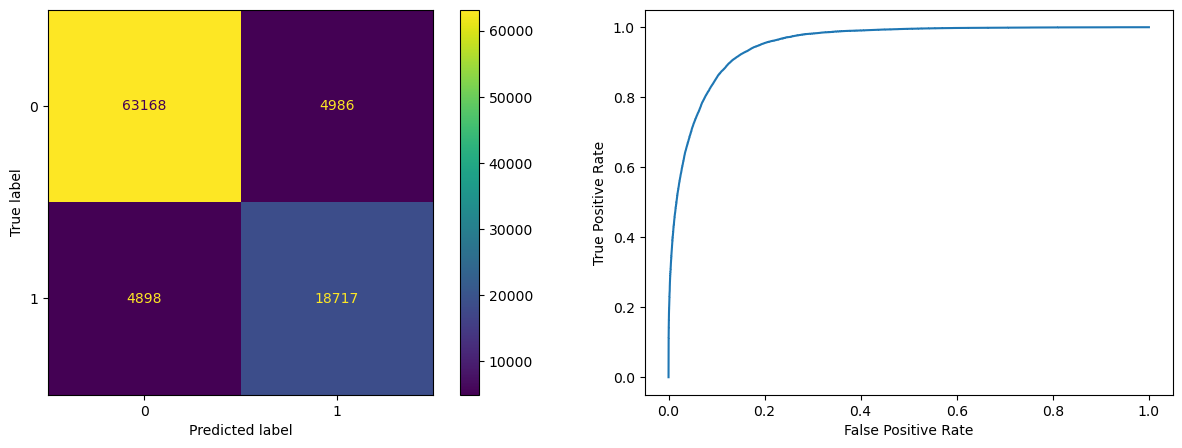

In [36]:
pred_y = xgb_clf.predict(test_df)
pred_prob_y = xgb_clf.predict_proba(test_df)
plt.title("Test results")
display_metrics(xgb_clf, test_y, pred_y, pred_prob_y)

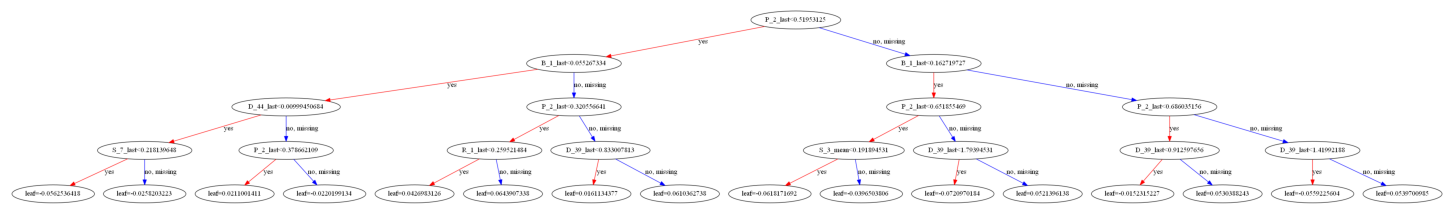

In [40]:
fig, ax = plt.subplots(figsize=(30, 30))
# Or get a matplotlib axis
ax = xgb.plot_tree(xgb_clf, num_trees=2, ax=ax)
plt.gcf().set_size_inches(18.5, 10.5)
# Get feature importances
plt.show()